# Current Problem Statement
I am on a gameshow, and the host has an unknown $\vec{x}$. I am trying to uncover that $\vec{x}$. He samples one row $
\vec{w_1}^T=[w_{11}, w_{12}, ..., w_{1n}]$ from the Walsh matrix without replacement and multiplies it with that $\vec{x}$ to get $\vec{y_1}$, which is now a scalar, since he sampled one row. I try to find all $\tilde{x}$ such that $\vec{w_1}\tilde{x}=\vec{y_1}$ is satisfied. I must end up with at most $_{n}C_{k}$ $\tilde{x}$'s, including one that is actually equal to $x$. I keep these all in a pool. Then, the host samples another row, forming the matrix: 

$\hat{W}=\begin{bmatrix}
\vec{w_1}^T \\
\vec{w_2}^T
\end{bmatrix}$

Select the $\tilde{x}$'s from the set we have that are consistent with $\hat{W}{x}={\vec{y_2}}$. We should have less than $_{n}C_{k}$ solutions. However, once the host samples $\frac{klog_{2}(N)}{log_{2}(K)}$ rows, we should only have one unique solution, which is the correct $x$. If we don't, this is an unsuccessful run.

Later, develop a deep policy/reinforcement learning network that can cleverly sample rows of the Walsh matrix such that $x$ is uncovered at the optimal time.

**Note**: Solution will not scale well.

Number of possible x vectors: 30240



Actual optimal iteration: 8
Mean optimal iteration: 6.84


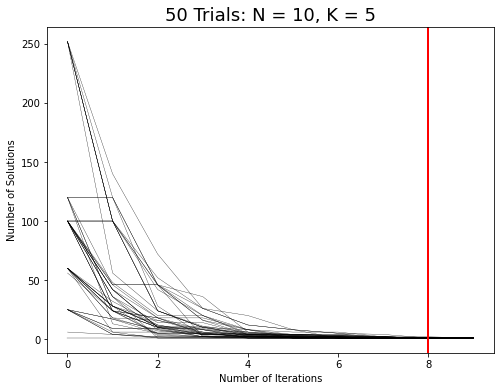

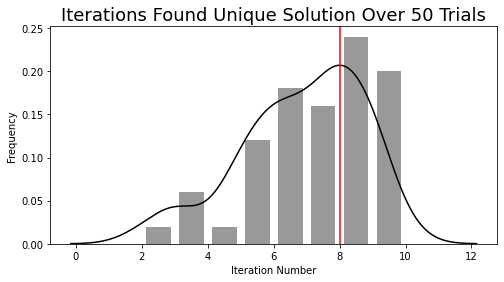

In [108]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial, ceil
from tqdm.auto import trange, tqdm


# Helper Functions
def to_binary(n, N):
    """
    Get binary representation of input n

    :param n: Integer of which to get binary representation
    :param N: Length of bitstring
    :return: str
    """
    return bin(n).replace('0b', '').zfill(N)


def get_w_hat_t_helper(row_idx, col_idx, N):
    """
    Helper function to get entry (t, col_idx) of W-H matrix

    :param row_idx: Row index of W-H matrix to find
    :param col_idx: Column index of W-H matrix to find
    :param N: Order of W-H matrix
    :return: int
    """
    row_bin = to_binary(row_idx, N)
    col_bin = to_binary(col_idx, N)

    row_list = [int(row_bit) for row_bit in list(row_bin[::-1])]
    col_list = [int(col_bit) for col_bit in list(col_bin[::-1])]

    result = 0
    for row_bit, col_bit in zip(row_list, col_list):
        result += row_bit * col_bit

    result = int((1 + ((-1) ** result)) / 2)
    return result


def get_x_vector(N, K):
    """
    Return x from given order of WH matrix and K

    :param N: Order of WH matrix
    :param K: Number of ones
    :return: numpy.ndarray
    """
    x = np.zeros(N)
    random_pos = np.random.choice(
        np.arange(0, N), K, replace=False
    )
    x[random_pos] = 1
    return x


def get_w_hat_t(t_idx: int, N):
    """
    Get t-th row of W-H matrix of order _N

    :param t_idx: Index of row in W-H matrix
    :return: list
    """
    row = []
    for i in range(N):
        row.append(get_w_hat_t_helper(t_idx, i, N))

    return row


def get_all_1_k_vectors(N, K):
    vector = [1] * K + [0] * (N - K)
    return list(set(itertools.permutations(vector, N)))


def check_x_set(all_x, A, b):
    valid_x = set()
    for x_vector in all_x:
        if (A @ x_vector == b).all():
            valid_x.add(x_vector)
    
    return list(valid_x)


def recover_x(N, K):
    W = np.array([get_w_hat_t(i, N) for i in range(N)])
    x = get_x_vector(N, K)

    row_pos = np.random.choice(np.arange(0, N), N, replace=False)

    # First row sampling
    W_hat = W[row_pos[0]]
    y = W_hat @ x
    all_x = get_all_1_k_vectors(N, K)
    valid_solutions = check_x_set(all_x, W_hat, y)
    num_solutions = [len(valid_solutions)]
    iteration_found = []

    for i, row_idx in enumerate(row_pos[1:]):
        # Oracle samples row
        W_hat = np.vstack((W_hat, W[row_idx]))
        y = W_hat @ x
        valid_solutions = check_x_set(valid_solutions, W_hat, y)
        if len(valid_solutions) == 1:
            iteration_found.append(i + 2)
        num_solutions.append(len(valid_solutions))
    
    x_tilde = []
    optimum_found = N
    
    # If x was successfully recovered
    if len(valid_solutions) == 1:
        x_tilde = list(valid_solutions[0])
        optimum_found = iteration_found[0]

    opt = ceil(K * np.log2(N) / np.log2(K))
    plt.plot(num_solutions, lw=0.3, c='black')
    plt.ylabel('Number of Solutions')
    plt.xlabel('Number of Iterations')
    plt.axvline(opt, c='r')
    
    return x_tilde, optimum_found
    
    
def plot_recover_x_trials(n, N, K):
    plt.figure(figsize=(8, 6))
    n_perms = int(factorial(N) / factorial(N - K))
    print(f'Number of possible x vectors: {n_perms}')
    iteration_found = []
    for i in tqdm(range(n)):
        x, it = recover_x(N, K)
        iteration_found.append(it)
    plt.title(f'{n} Trials: N = {N}, K = {K}', fontsize=18)
    plt.figure(figsize=(8, 4))
    sns.distplot(iteration_found, color='black', hist_kws={'rwidth':0.75})
    opt = ceil(K * np.log2(N) / np.log2(K))
    plt.axvline(opt, c='r')
    plt.title(f'Iterations Found Unique Solution Over {n} Trials', fontsize=18)
    plt.xlabel('Iteration Number')
    plt.ylabel('Frequency')
    print(f'Actual optimal iteration: {opt}')
    print(f'Mean optimal iteration: {np.mean(iteration_found)}')
        
plot_recover_x_trials(50, 10, 5)